### 1. Quick EDA and cleaning
### 2. Baseline with HistGradientBoostingClassifier
### 3. Initial Scoring of Classifiers
### 4. Hyperparams Tuning
### 5. Voting Ensemble

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### 1. Quick EDA and cleaning
#### In this notebook I decided to drop the columns with more than 50% of records missing, and then drop the records with other missing values. In other notebooks I try to impute the missing values using ML

In [3]:
data = pd.read_csv("/home/anopsy/Portfolio/equity_healthcare_kaggle/training.csv")

In [4]:
data.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [5]:
import missingno as msno
%matplotlib inline

<Axes: >

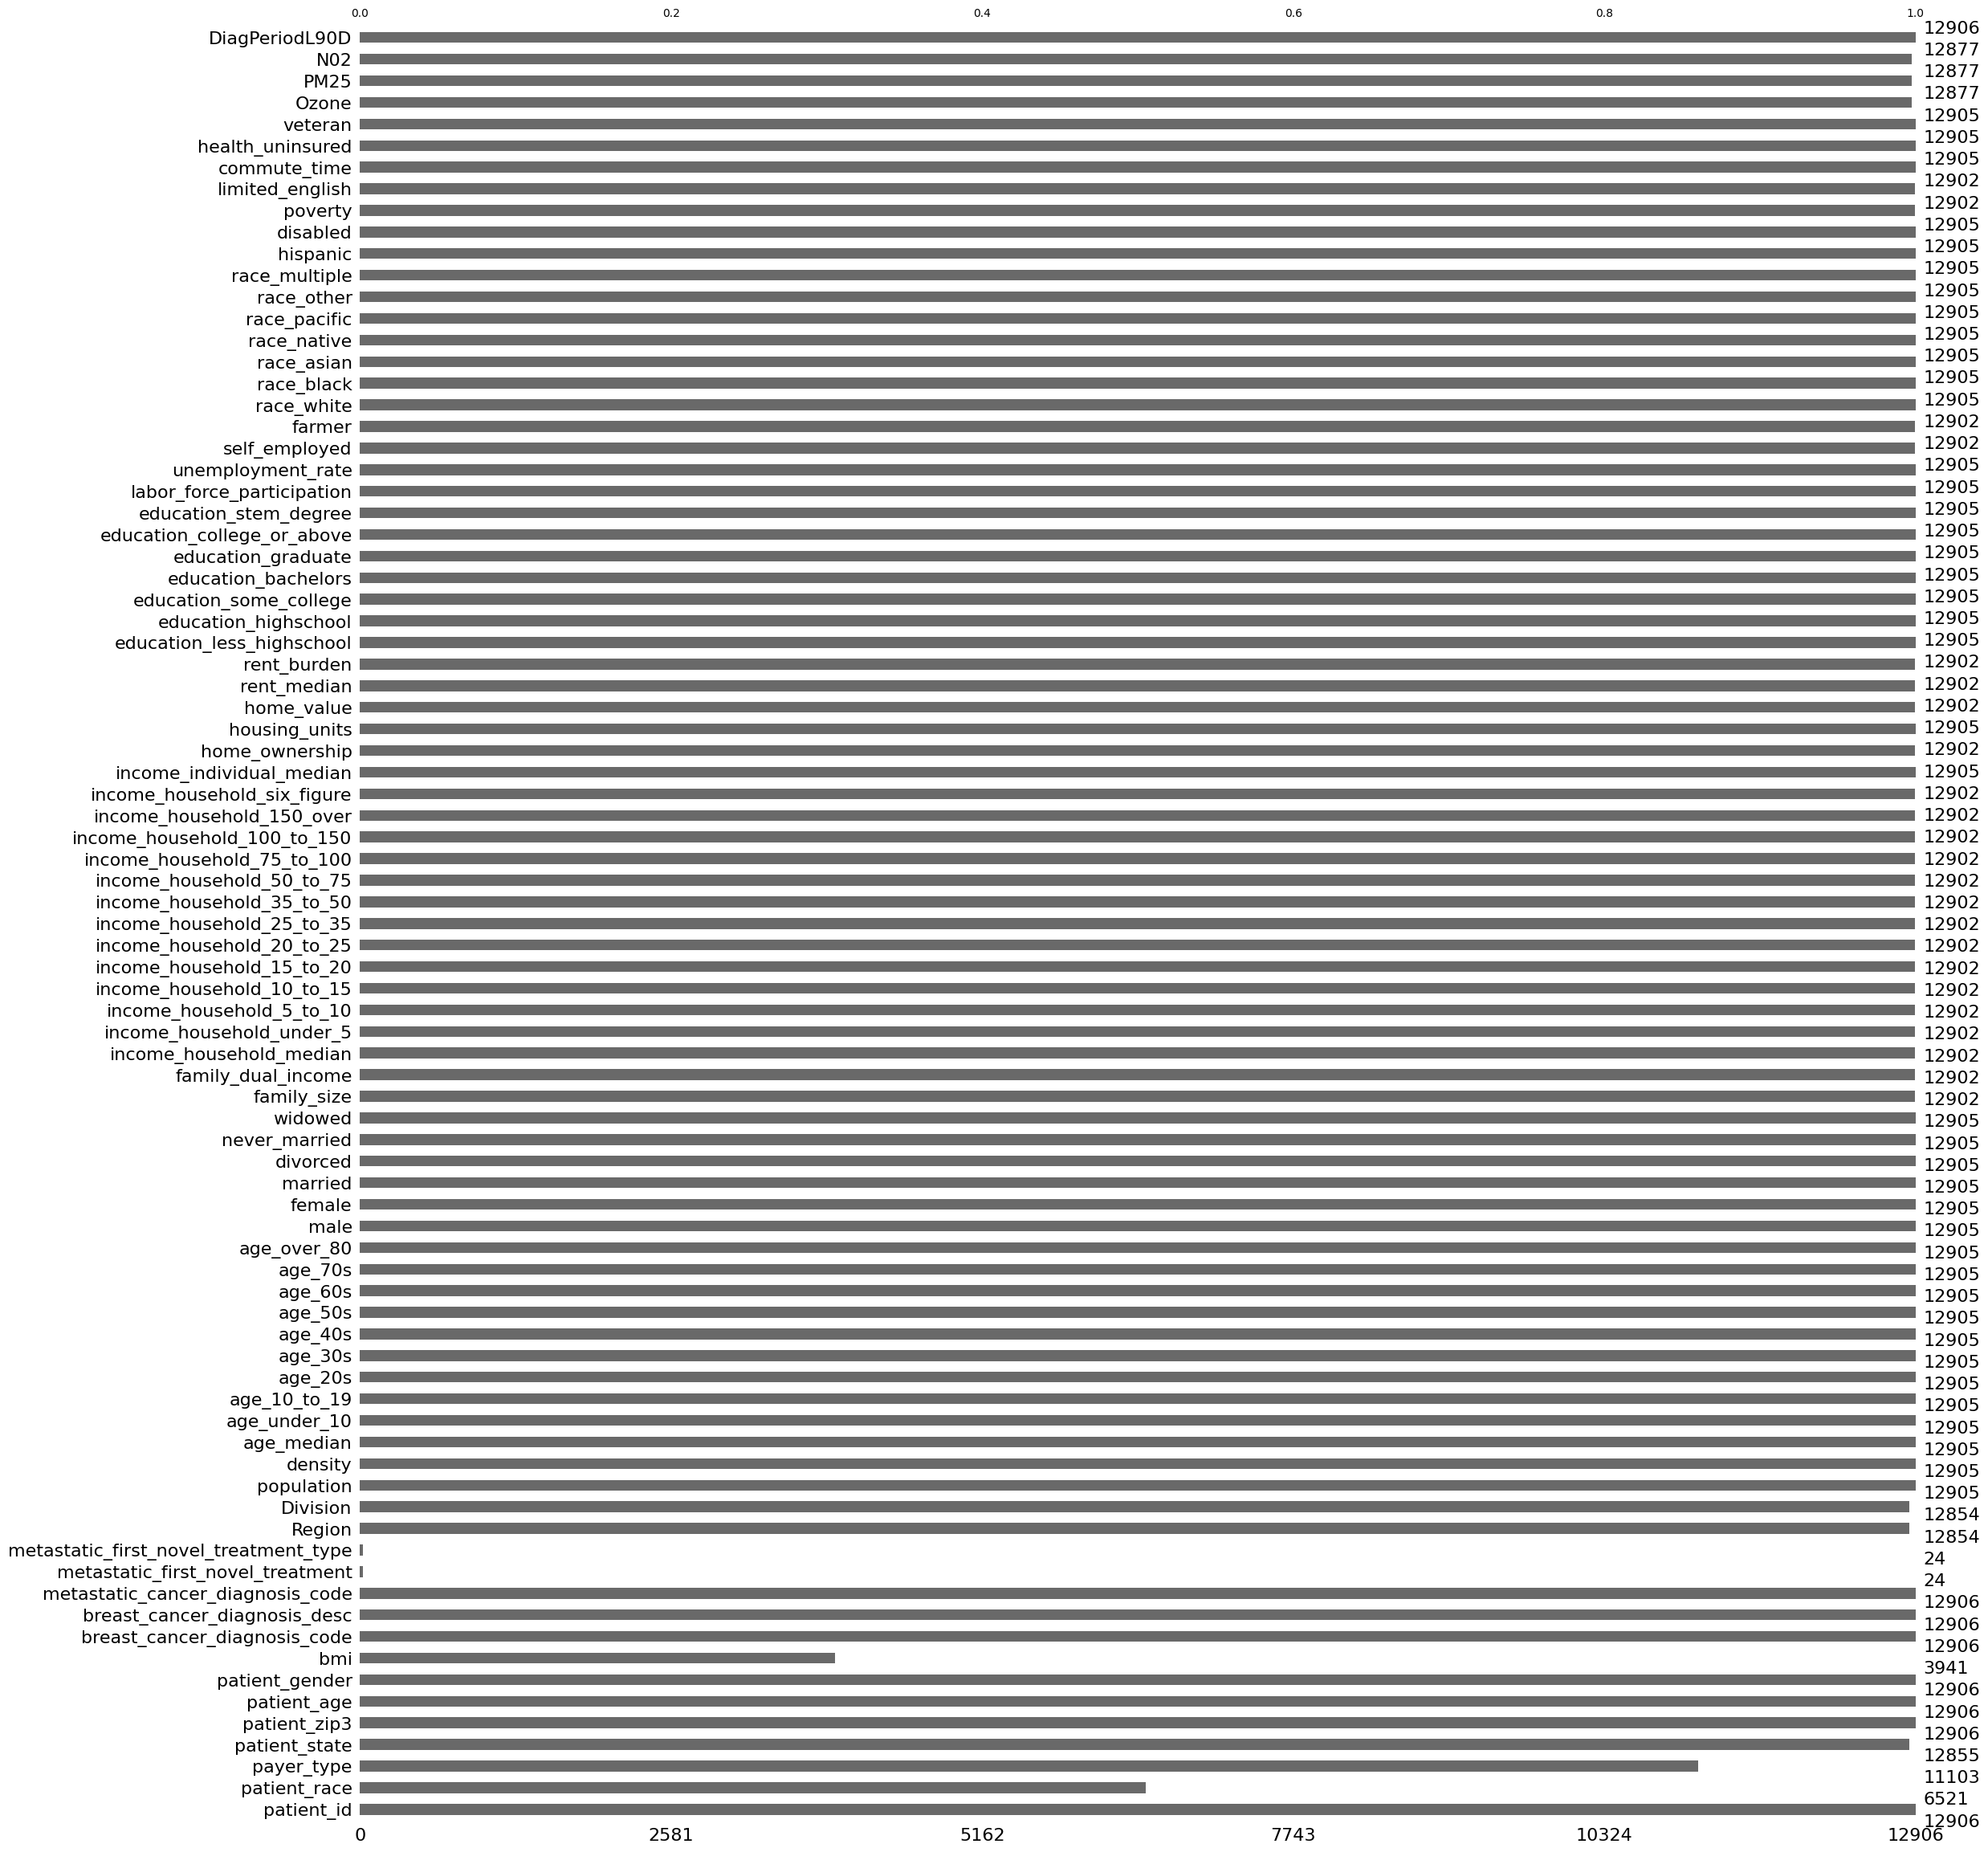

In [6]:
msno.bar(data)

In [7]:
clean_data = data.drop(columns=["metastatic_first_novel_treatment","metastatic_first_novel_treatment_type","bmi","patient_race"])

In [8]:
clean_data = clean_data.dropna()
clean_data.shape

(11043, 79)

In [9]:
clean_data["patient_zip3"] = clean_data["patient_zip3"].astype("category")
clean_data["DiagPeriodL90D"] = clean_data["DiagPeriodL90D"].astype("category")
clean_data["diag_description"] = clean_data["breast_cancer_diagnosis_desc"].astype("string")

In [10]:
cat_col = clean_data.select_dtypes(include="object").columns.tolist()
for col in cat_col:
    clean_data[col] = clean_data[col].astype("category") #pretty sure I can do it somehow in one line

In [11]:
cat_col = clean_data.select_dtypes(include="category").columns.tolist()
num_col = clean_data.select_dtypes(include="number").columns.tolist()
print(cat_col)
num_col = num_col[1:]
cat_col = cat_col[:-1]

['payer_type', 'patient_state', 'patient_zip3', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Region', 'Division', 'DiagPeriodL90D']


In [12]:
cat_viz = cat_col.copy()
cat_viz.append("DiagPeriodL90D")

In [13]:
num_viz = num_col.copy()
num_viz.append("DiagPeriodL90D")

In [14]:
import joypy  
from matplotlib import cm

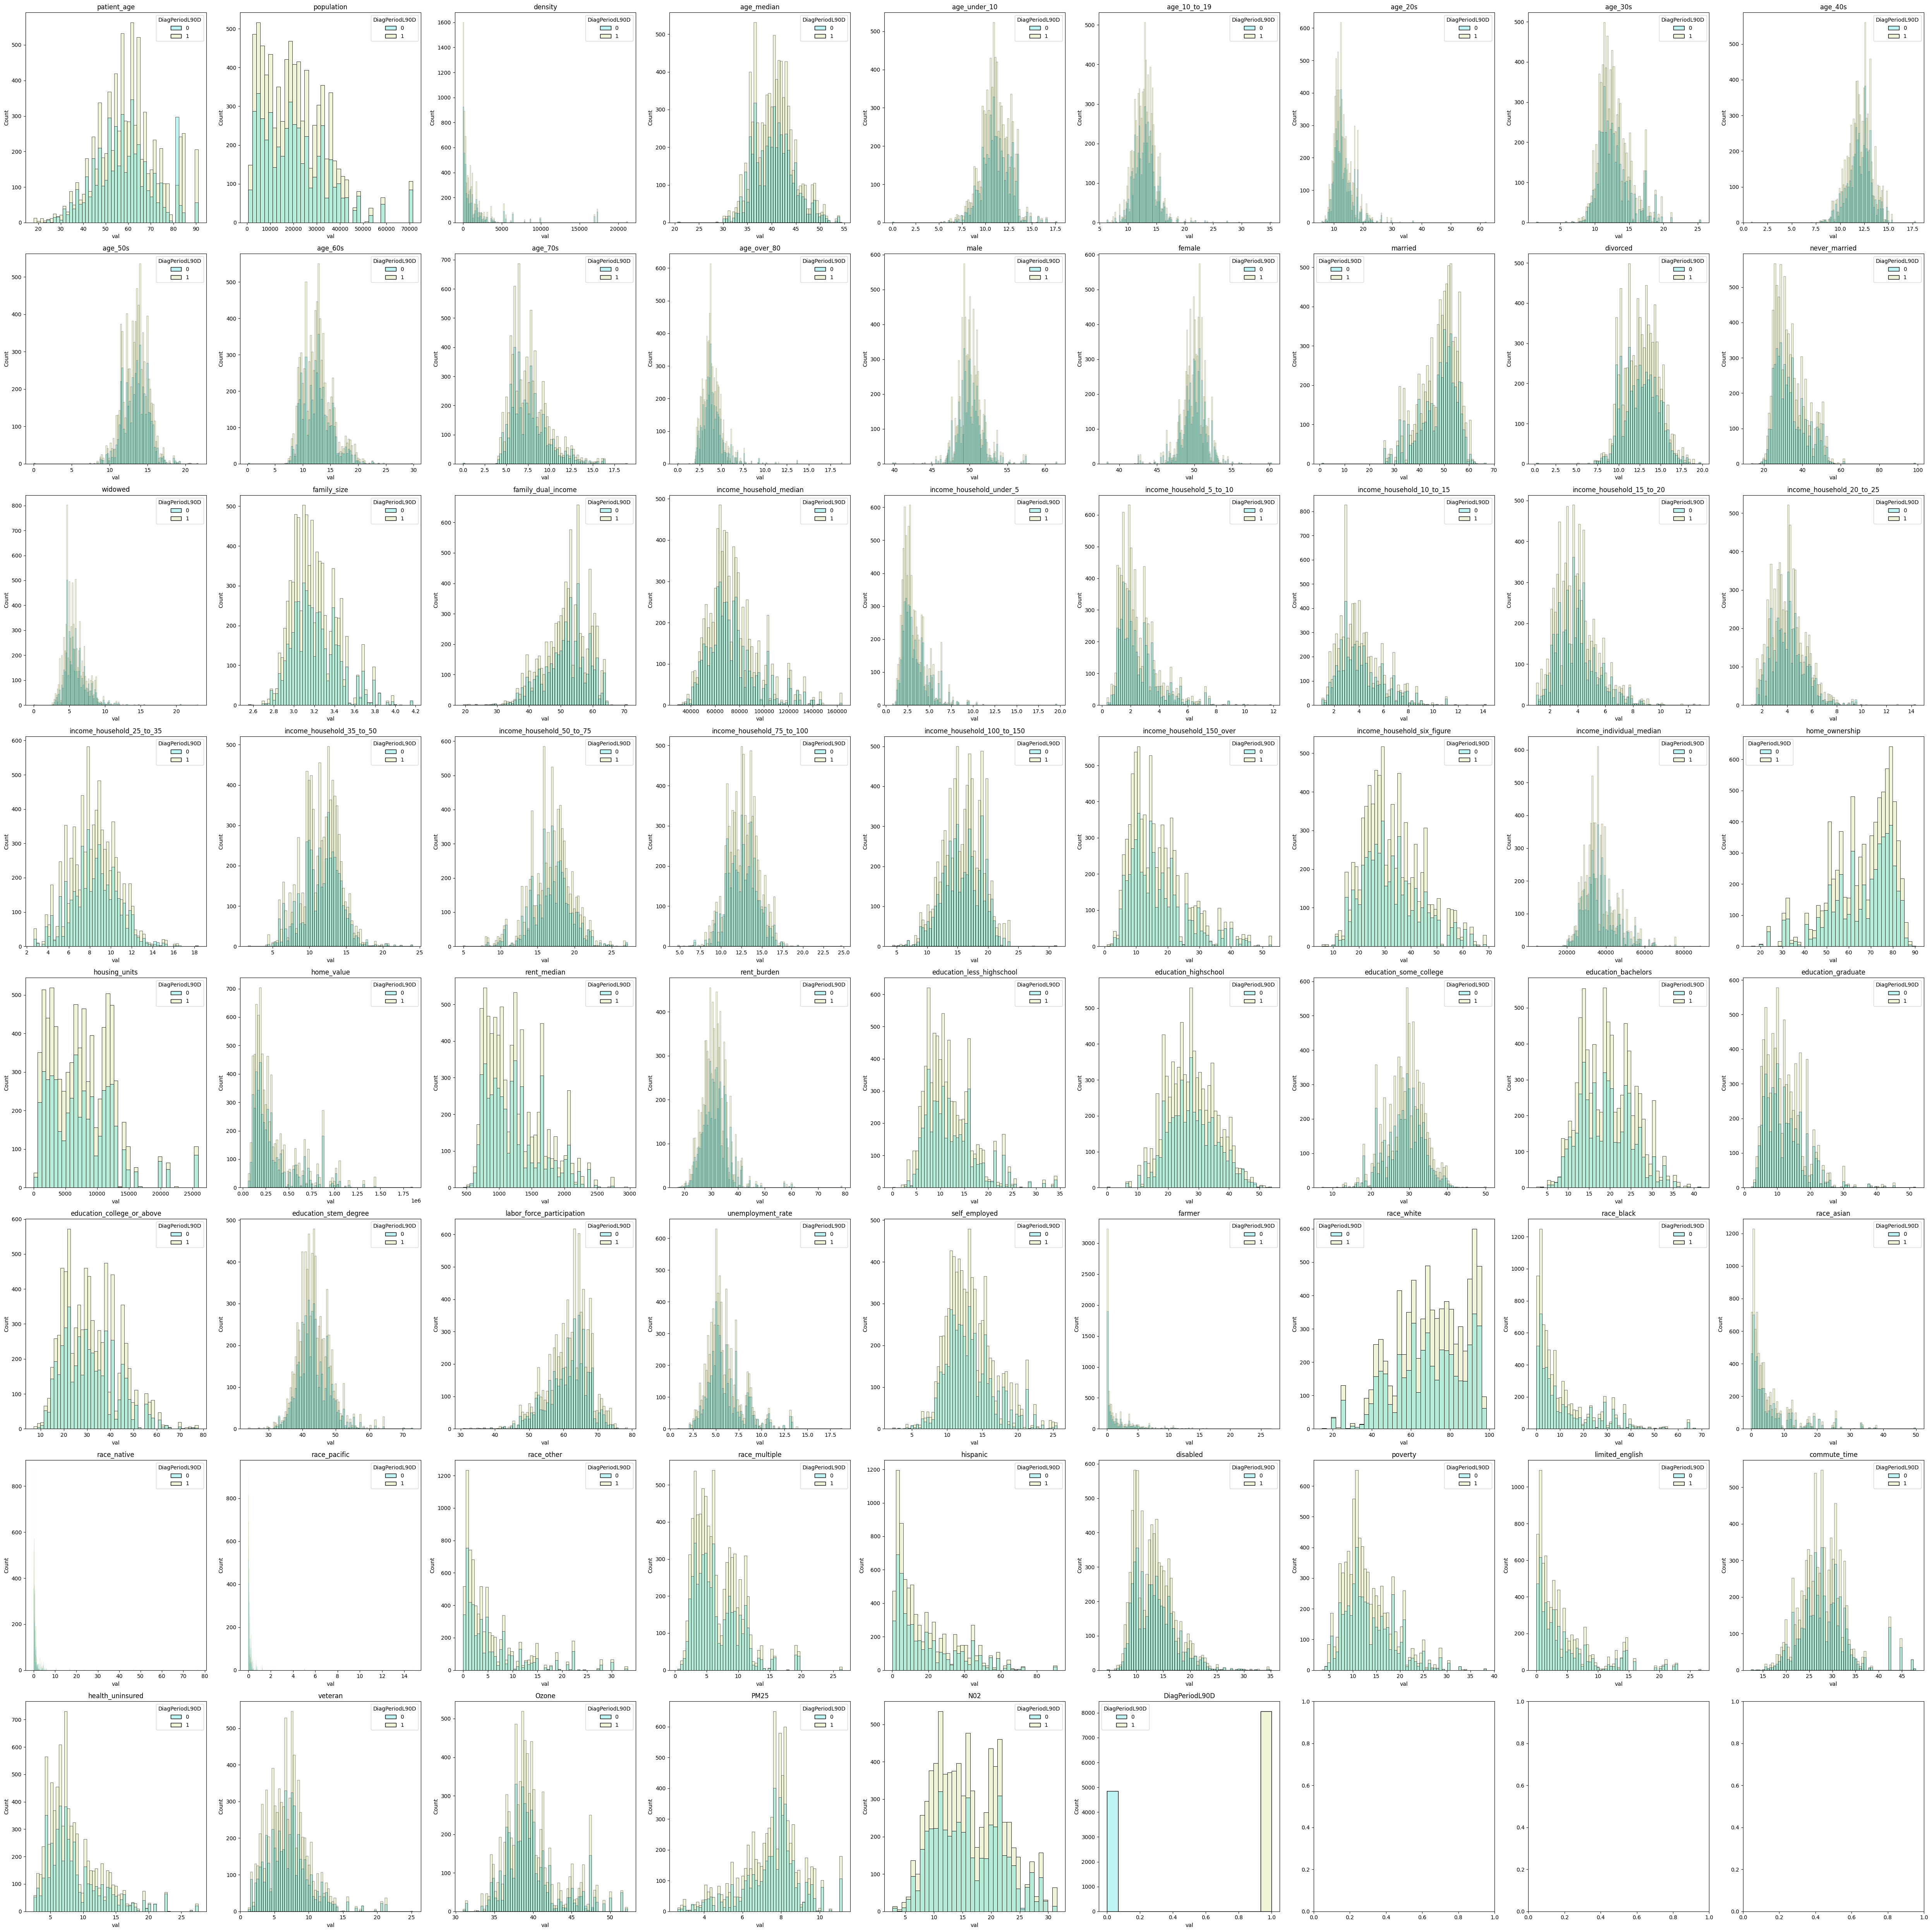

<Figure size 640x480 with 0 Axes>

In [16]:
fig, axs = plt.subplots(8,9, figsize=(50, 50))
axs = axs.flatten()

for i, col in enumerate(num_viz):
    sns.histplot(data=data[num_viz], x=col, ax=axs[i], hue = "DiagPeriodL90D",alpha=0.3, palette = 'rainbow')
    axs[i].set_title(col)
    axs[i].set_xlabel('val')

plt.tight_layout()
plt.show()
plt.savefig('histplot_dist.png', dpi=150)
plt.clf()

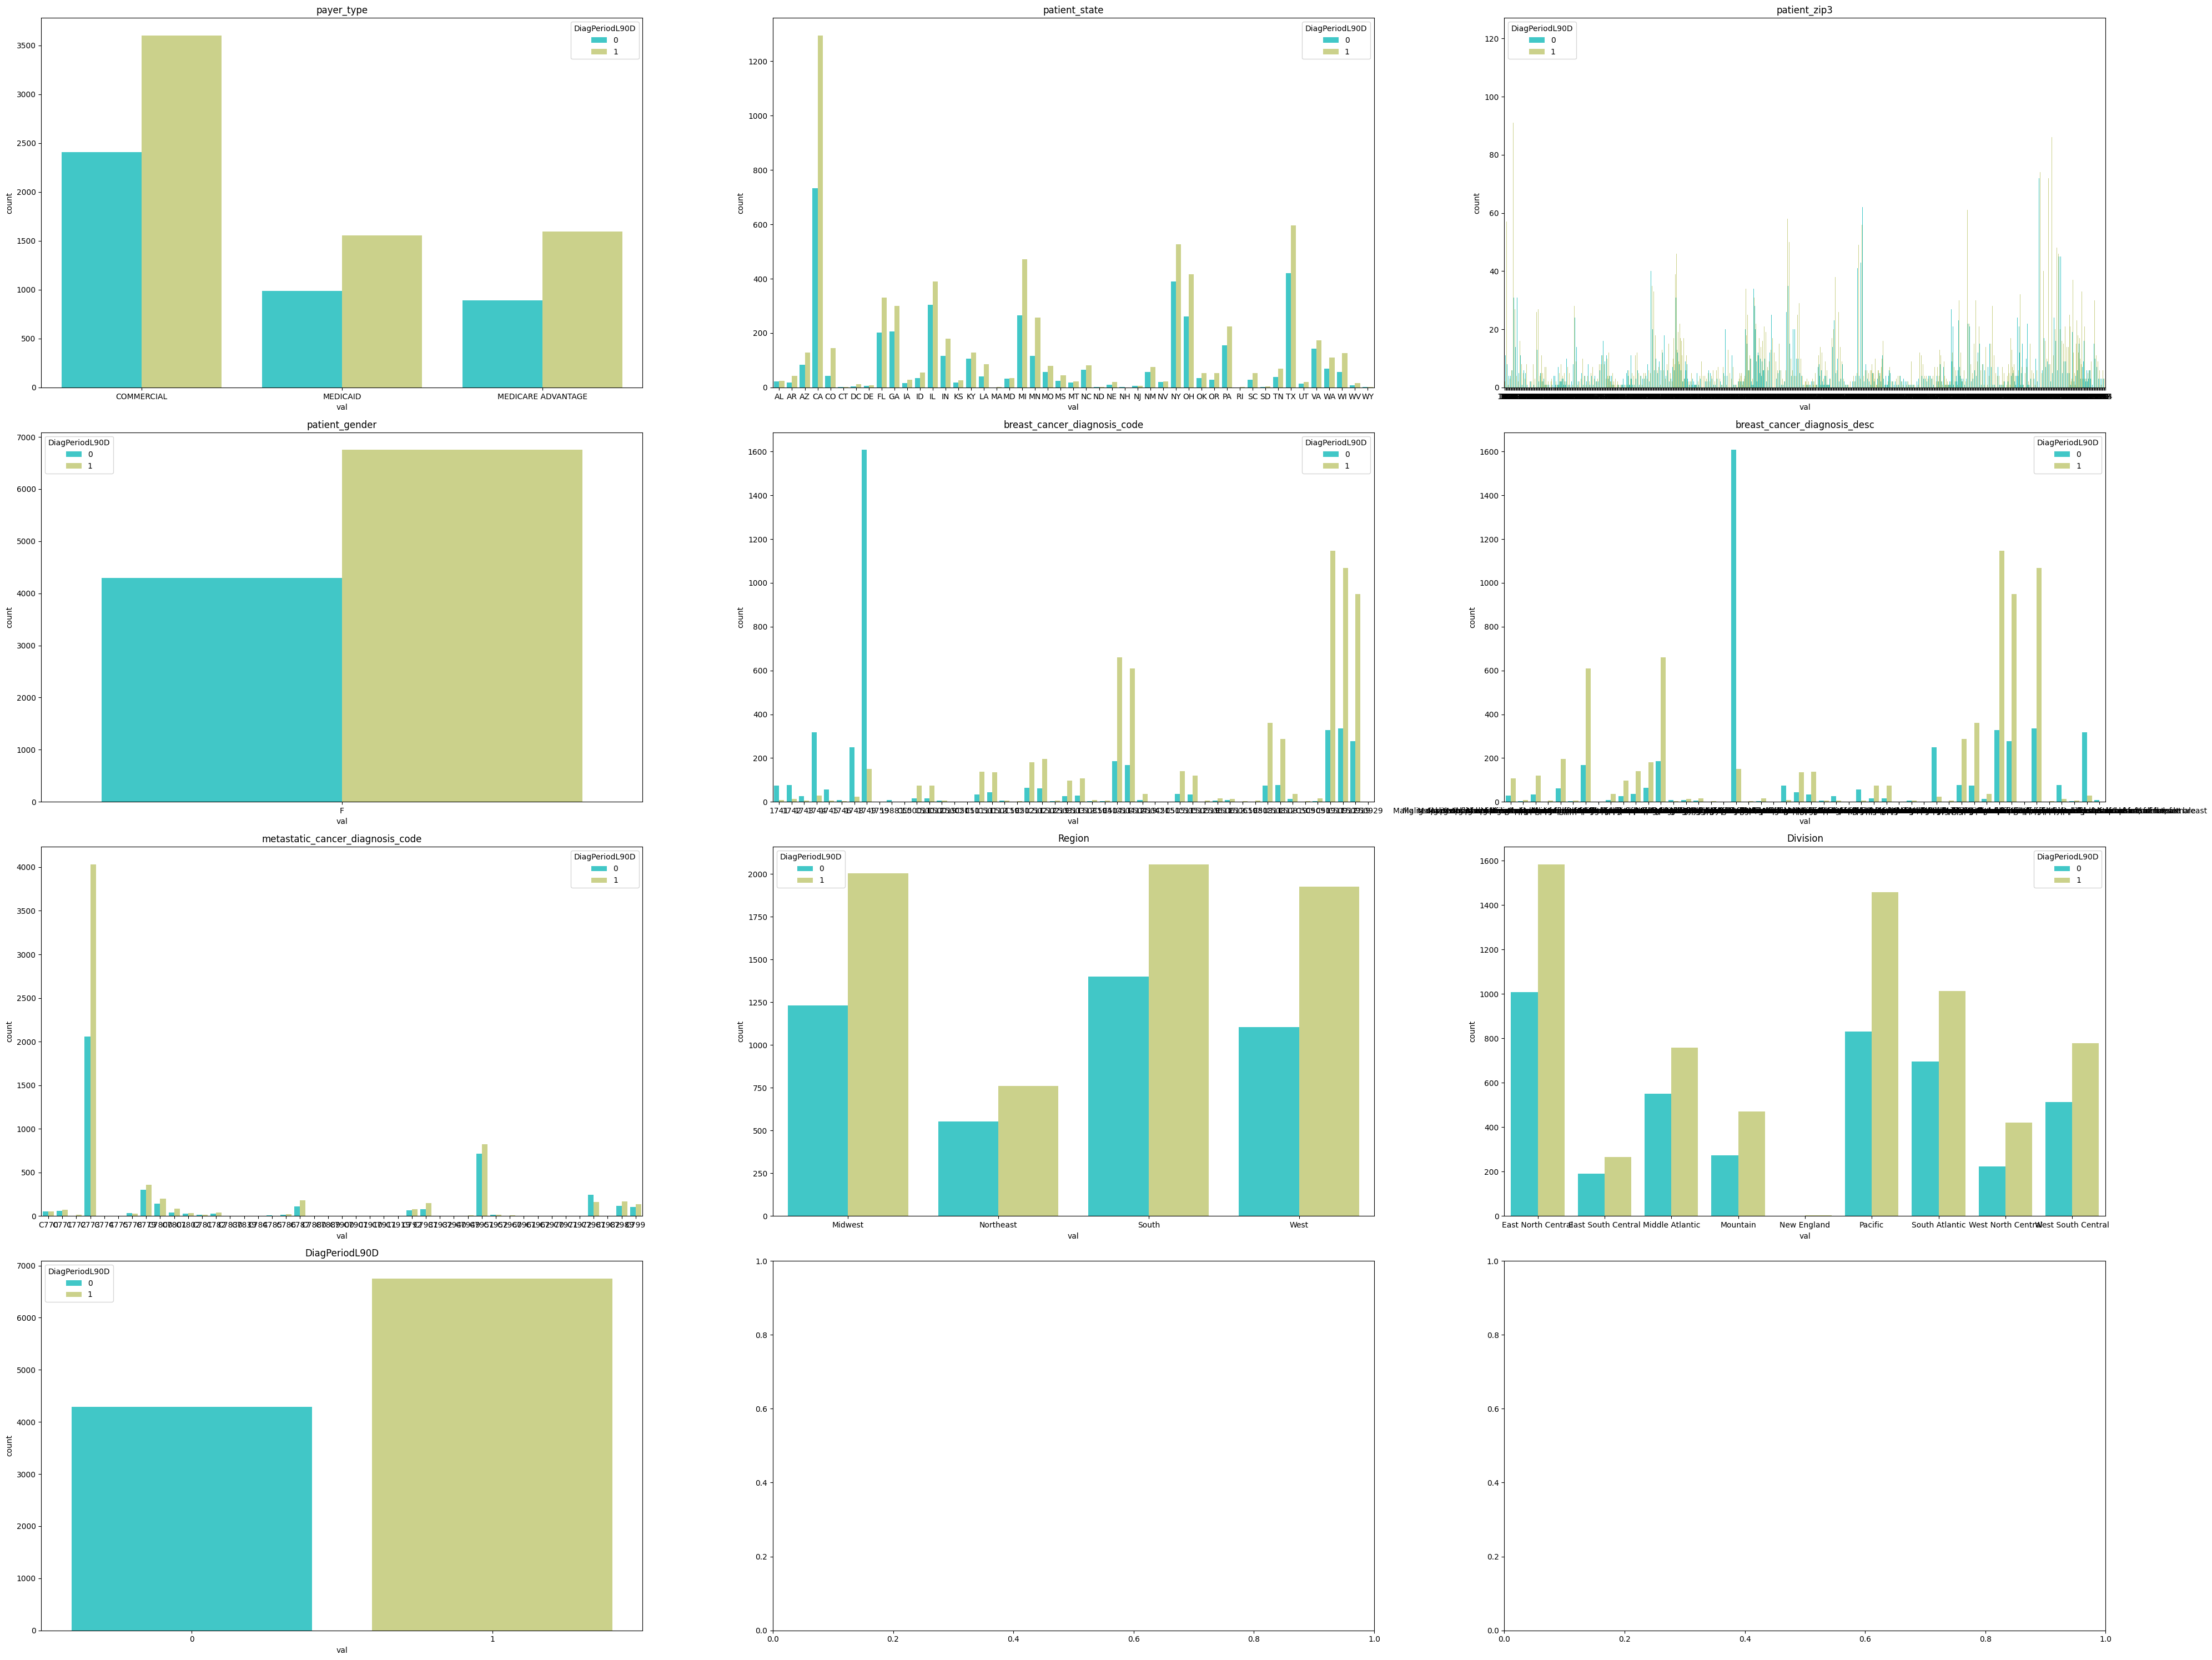

<Figure size 640x480 with 0 Axes>

In [17]:
fig, axs = plt.subplots(4,3, figsize=(40, 30))
axs = axs.flatten()

for i, col in enumerate(cat_viz):
    sns.countplot(data=clean_data[cat_viz], x=col, ax=axs[i], hue = "DiagPeriodL90D", palette = 'rainbow')
    axs[i].set_title(col)
    axs[i].set_xlabel('val')

plt.tight_layout()
plt.show()
plt.savefig('countplot_dist.png', dpi=150)
plt.clf()

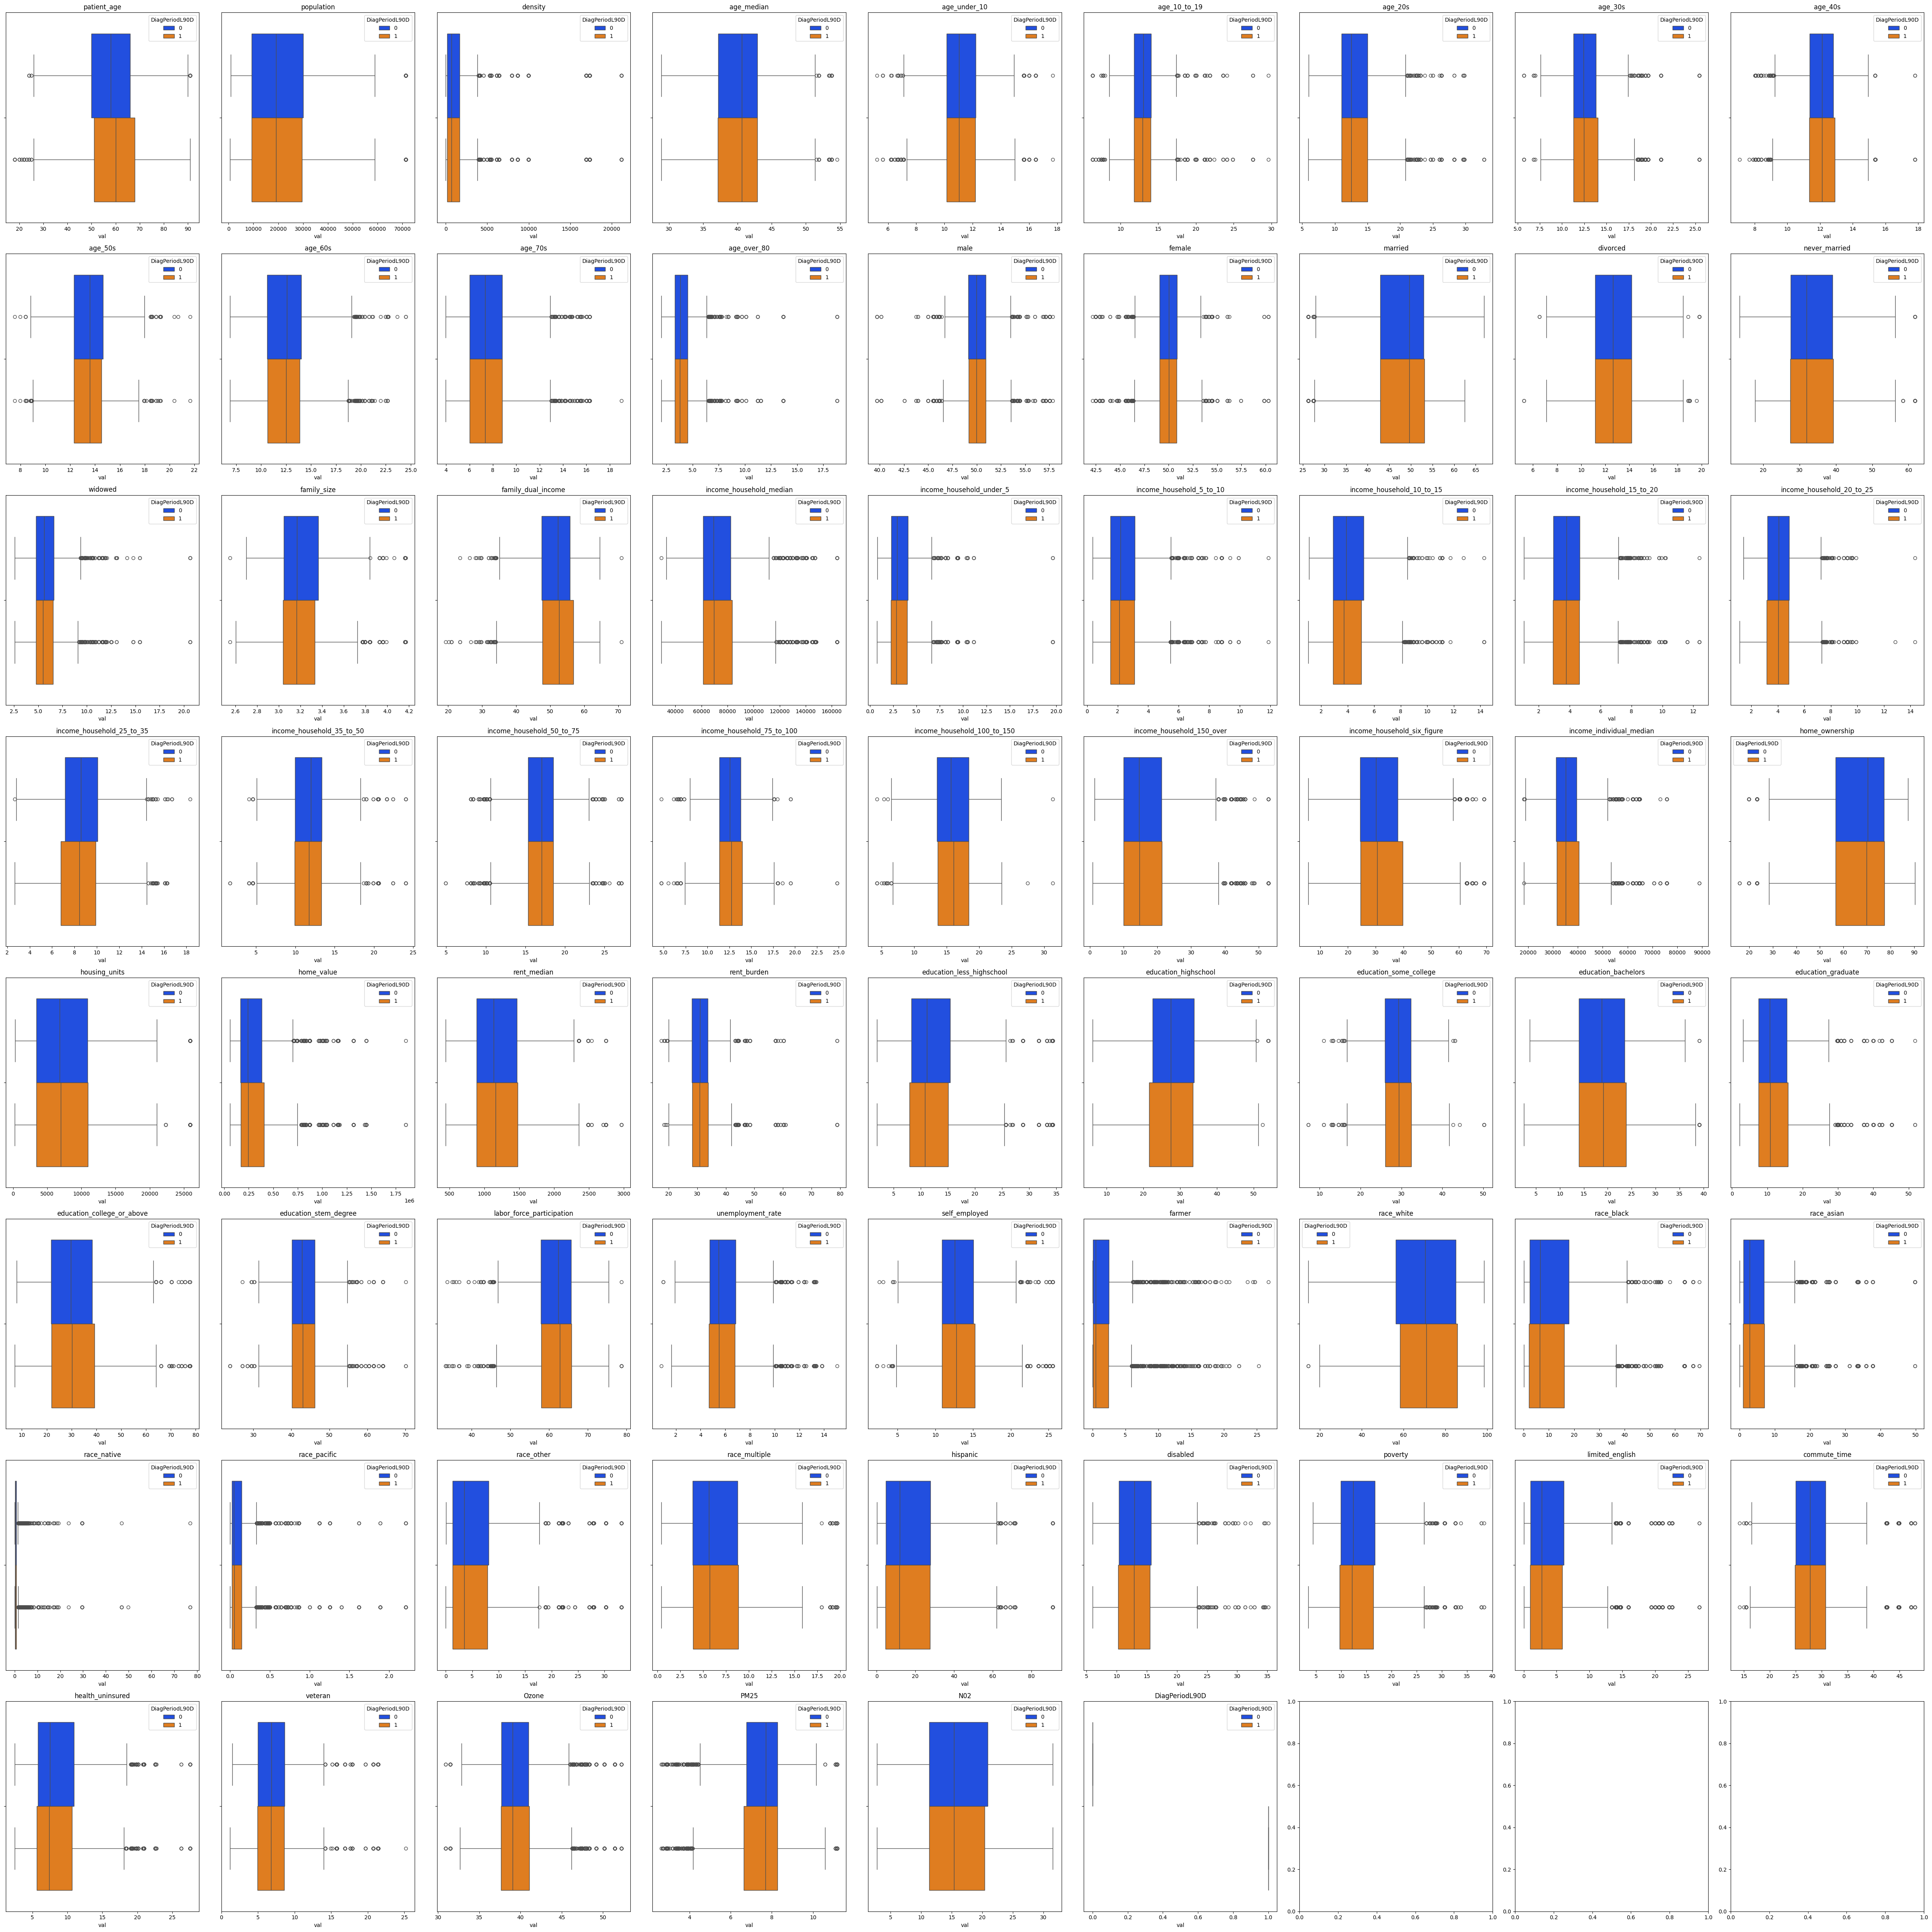

<Figure size 640x480 with 0 Axes>

In [18]:
fig, axs = plt.subplots(8,9, figsize=(50, 50))
axs = axs.flatten()

for i, col in enumerate(num_viz):
    sns.boxplot(data=clean_data[num_viz], x=col, ax=axs[i], hue = "DiagPeriodL90D", palette = 'bright')
    axs[i].set_title(col)
    axs[i].set_xlabel('val')

plt.tight_layout()
plt.show()
plt.savefig('boxplot_dist.png', dpi=150)
plt.clf()

### 2. Baseline with HistGradientBoostingClassifier
#### Using HistGradientBoostingClassifier to get an initial idea of my pipeline and baseline results

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.metrics import confusion_matrix, roc_auc_score

In [20]:
X = clean_data.drop(columns=["DiagPeriodL90D"])
y = clean_data["DiagPeriodL90D"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state = 2137)

In [21]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

In [22]:
col_transformer = make_column_transformer(
    (StandardScaler(), num_col),
    (OneHotEncoder(handle_unknown='ignore'), cat_col),
    (CountVectorizer(stop_words="english"), "diag_description"),
)

In [23]:
mod_pipe = make_pipeline(
    col_transformer,
    DenseTransformer(),
    HistGradientBoostingClassifier()
)

In [24]:
mod_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['patient_age', 'population',
                                                   'density', 'age_median',
                                                   'age_under_10',
                                                   'age_10_to_19', 'age_20s',
                                                   'age_30s', 'age_40s',
                                                   'age_50s', 'age_60s',
                                                   'age_70s', 'age_over_80',
                                                   'male', 'female', 'married',
                                                   'divorced', 'never_married',
                                                   'widowed', 'family_size',
                                                   'family_dual_i...
                                                   'patient_gender',
                                                   'breast_cancer_diagnosis_code',
                                                   'breast_cancer_diagnosis_desc',
                                                   'metastatic_cancer_diagnosis_code',
                                                   'Region', 'Division']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'diag_description')])),
                ('densetransformer',
                 <__main__.DenseTransformer object at 0x741d3c6e21a0>),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [25]:
y_pred = mod_pipe.predict(X_test)

In [26]:
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, np.round(y_pred)))


0.7586557268086452
[[ 721  518]
 [ 134 1940]]


### 3. Initial Scoring of Classifiers
#### Let's try different estimators and compare their results

In [27]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

In [28]:
models = [
    ('xgb', XGBClassifier(objective='binary:logistic', verbose=0)),
    ('lgbm', LGBMClassifier(objective ='binary', verbosity=-1)),
    ('cat', CatBoostClassifier(silent=True)),
    ('ada', AdaBoostClassifier()),
    ('logreg_l1', LogisticRegression(solver='liblinear',penalty='l1')),
    ('logreg_l2', LogisticRegression(solver='liblinear',penalty='l2')),
    ('sgd', SGDClassifier(loss='log_loss', penalty='elasticnet')),
    ('random_forest', RandomForestClassifier()),
    ('svc', LinearSVC()),
]

In [29]:
pipes = {}
for model in models:
    pipe = Pipeline(steps = [('data_prep', col_transformer), model], verbose=False)
    pipe.fit(X_train, y_train)
    pipes[pipe.steps[1][0]] = pipe

In [30]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, log_loss

In [31]:
_metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score), 'accuracy':'accuracy','logloss':make_scorer(log_loss)}
metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),'accuracy':'accuracy','logloss':make_scorer(log_loss)}
#metrics={'roc_auc': make_scorer(roc_auc_score)}
#_metrics={'roc_auc': make_scorer(roc_auc_score)}
mod_names=[model[0] for model in models]

def score_cv(estimators=mod_names,n_splits=5,metrics=metrics):
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        pipe=pipes[pipe_name]
        labels.append(pipe_name)
        #print(labels)
        kf = KFold(n_splits)
        model_score=cross_validate(pipe, X_train, y_train, scoring=metrics, cv=kf)
        scorers.append(model_score)
        #print(scorers)
    
    score_lists={}
    for metric in metrics:
        print(metric)
        score_lists[metric] = [score['test_' + metric] for score in scorers]
    return score_lists, labels


In [32]:
def plot_scores(score_lists, labels, suffix):
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list, palette='hls').set_xticklabels(labels, rotation=45)
        plt.title(title)
        plt.savefig(title+suffix+'_score.png', dpi=150)

In [33]:
score_lists, labels = score_cv()

f1
auc
accuracy
logloss


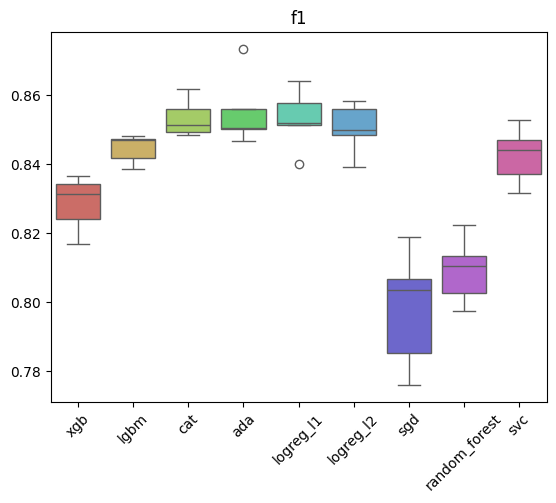

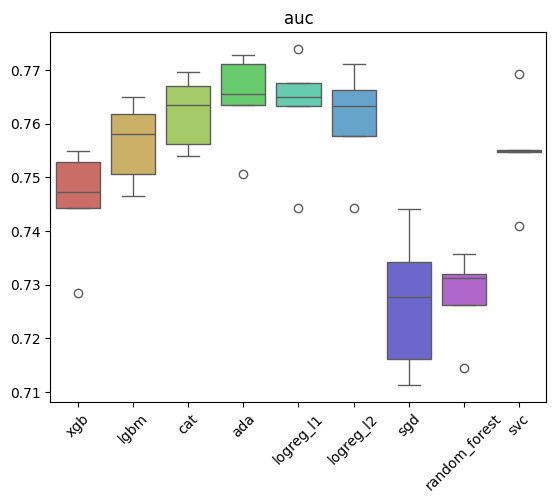

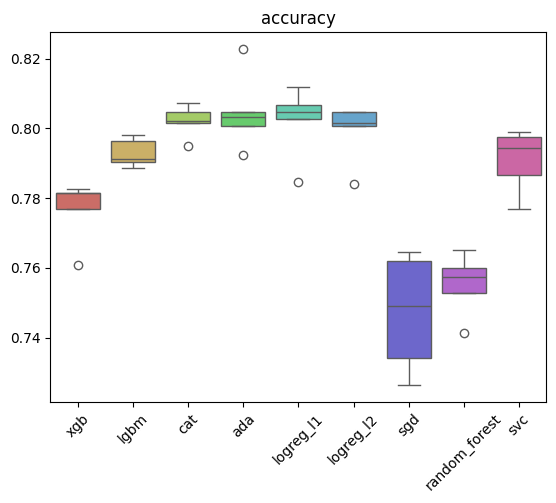

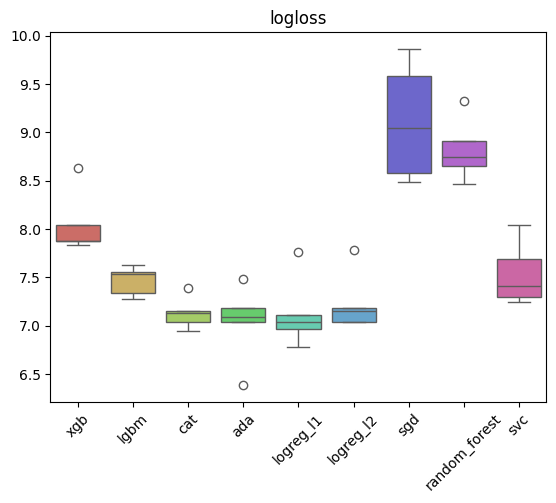

In [34]:
plot_scores(score_lists, labels, 'init')

### 4. Hyperparams Tuning
#### Let's tune the hyperparams for the given estimators

In [35]:
params_xgb = {
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__gamma': [0, 0.5, 1],
        'xgb__subsample': [0.6, 0.8],
        'xgb__colsample_bytree': [0.6, 0.8],
        'xgb__max_depth': [3, 4, 5],
        'xgb__learning_rate' : [0.001, 0.01,  0.05],
        'xgb__n_estimators' : [1000, 2000]
        }

params_lgbm = {
        'lgbm__bagging_fraction': [0.2, 0.5, 0.8],
        'lgbm__bagging_freq': [3, 5, 8],
        'lgbm__metric': ['AUC'],
        'lgbm__feature_fraction': [0.5, 0.8],
        'lgbm__max_depth': [8, 10, 13],
        'lgbm__min_data_in_leaf': [40, 60],
        'lgbm__num_leaves': [100, 200, 500],
        'lgbm__num_iterations' : [100, 200, 500]
}

params_cat = {
        'cat__iterations': [100, 200, 400],
        'cat__learning_rate': [0.01, 0.1 , 0.5],
        'cat__depth': [4, 5, 6],    
        'cat__min_data_in_leaf' : [50, 100, 150, 200]
    
}

params_ada = {
        'ada__learning_rate' : [0.001, 0.01, 0.02, 0.05],
        'ada__n_estimators' : [20, 500, 1500]
    
}

params_sgd = {
        'sgd__learning_rate' : ['optimal', 'adaptive'],
        'sgd__alpha' : [0.001, 0.01, 0.02, 0.05]
    
}

params_rf = {
        'random_forest__criterion' : ['gini', 'entropy', 'log_loss'],
        'random_forest__max_depth' : [3, 4, 5, None],
        'random_forest__n_estimators' : [100, 500, 1500],
        
}

params_svc =  {  
        'svc__C': [0.5, 1.0, 1.5]
}

params_logreg_l2 = {
        'logreg_l2__max_iter' : [50, 100, 200]
}

params_logreg_l1 = {
        'logreg_l1__max_iter' : [50, 100, 200]
}
params_list = [params_xgb, params_lgbm, params_cat, params_ada,  params_logreg_l1, params_logreg_l2, params_sgd, params_rf, params_svc]

In [36]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [37]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 2137)

In [38]:
model_names = list(pipes.keys())

In [39]:
params = zip(model_names, params_list)

In [40]:
def tune_params(params):
    scores = {}
    best_est = {}
    for model_name, param in params:
        pipe=pipes[model_name]
        tune_model = RandomizedSearchCV(pipe, param, n_iter=10, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=0, random_state = 2137)
        tune_model.fit(X_train, y_train)
        scores[model_name] = tune_model.cv_results_
        best_est[model_name] = tune_model.best_estimator_
    return scores, best_est

In [ ]:
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
scores, best_est = tune_params(params)

In [42]:
pipes = best_est

In [43]:
score_lists, labels = score_cv()

f1
auc
accuracy
logloss


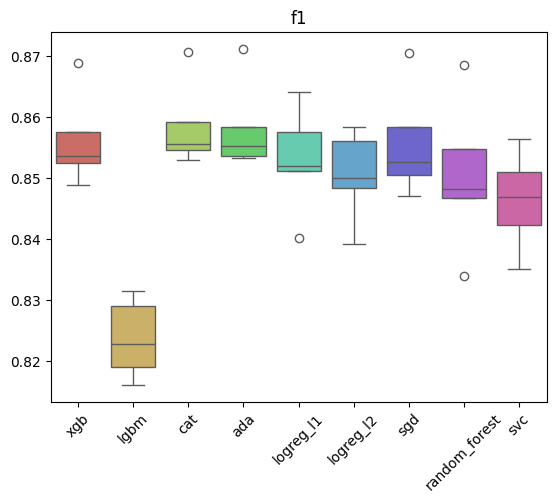

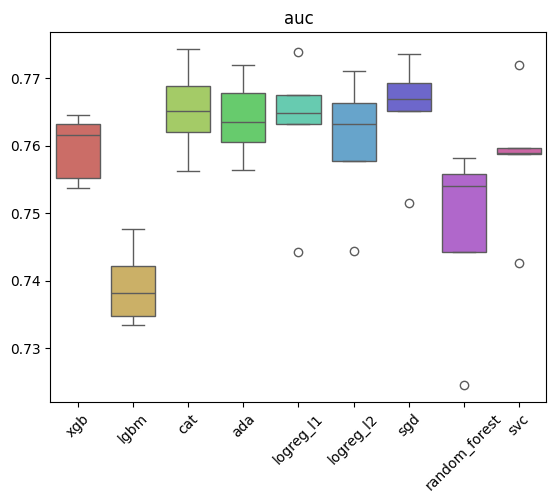

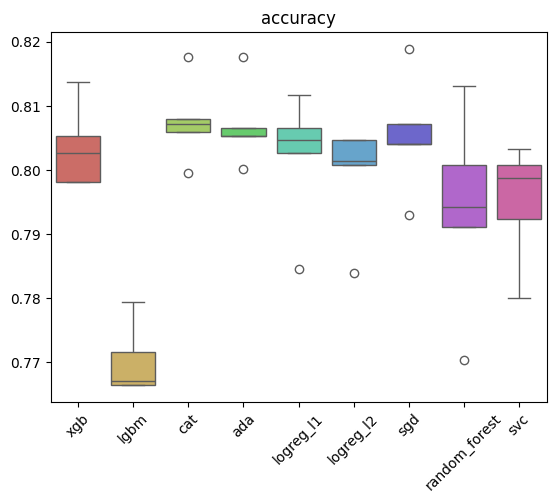

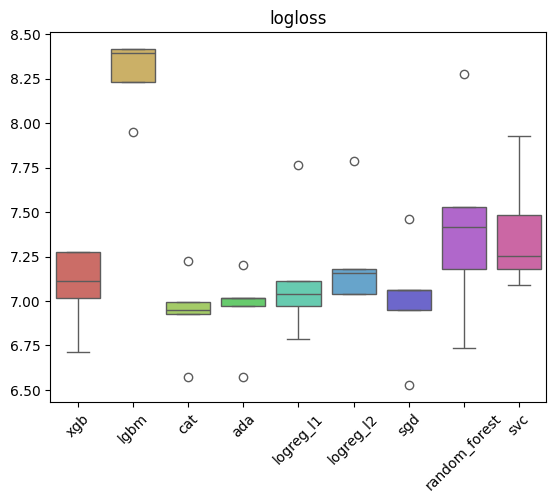

In [44]:
plot_scores(score_lists, labels, 'tuned')

### 5. Voting Ensemble
#### I've chosen the best 5 estimators and let them vote

In [56]:
classifiers= []
best_list=['xgb', 'cat', 'ada', 'logreg_l1', 'sgd']
for est in best_list:
    classifiers.append((est, best_est[est]))

In [60]:
clf_vote = VotingClassifier(
    estimators = classifiers,
    n_jobs=4
) 

In [61]:
clf_vote.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/anopsy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:59:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('data_prep',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['patient_age',
                                                                                 'population',
                                                                                 'density',
                                                                                 'age_median',
                                                                                 'age_under_10',
                                                                                 'age_10_to_19',
                                                                                 'age_20s',
                                                                                 'age_30s',
                                                                                 'age_40s',
                                                                                 'age_50s',
                                                                                 'age_60s',
                                                                                 'age_70s',
                                                                                 'age_over_80',
                                                                                 'male',
                                                                                 'female',
                                                                                 'married',
                                                                                 'divorced',
                                                                                 'never_married',
                                                                                 'widowed',...
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['payer_type',
                                                                                 'patient_state',
                                                                                 'patient_zip3',
                                                                                 'patient_gender',
                                                                                 'breast_cancer_diagnosis_code',
                                                                                 'breast_cancer_diagnosis_desc',
                                                                                 'metastatic_cancer_diagnosis_code',
                                                                                 'Region',
                                                                                 'Division']),
                                                                               ('countvectorizer',
                                                                                CountVectorizer(stop_words='english'),
                                                                                'diag_description')])),
                                              ('sgd',
                                               SGDClassifier(alpha=0.001,
                                                             loss='log_loss',
                                                             penalty='elasticnet'))]))],
                 n_jobs=4)

In [63]:
vote_pred = clf_vote.predict(X_test)

In [65]:
print(confusion_matrix(y_test, vote_pred))

[[ 701  538]
 [  85 1989]]


In [66]:
print(f1_score(y_test, vote_pred))

0.8645946533362312


In [68]:
print(accuracy_score(y_test, vote_pred))

0.8119529127678841
